In [ ]:
import numpy as np
import json
import copy
import glob

from skimage.measure import find_contours
import skimage.color
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import patches, lines
from matplotlib.patches import Polygon
import cv2
import IPython.display
from PIL import Image, ImagePalette
from pycocotools.coco import COCO

Tools

In [ ]:
def compile_image_list(image_number, image_file, file_name_len):
    
    image_list = [image_file[i][file_name_len:] for i in image_number]
    return image_list

def exclude_images(annotations, image_list):

    # Filter images by file name
    ex_images = list()
    ex_images_id = list()
    in_images = list()
    for image in annotations["images"]:
        if image["file_name"] in image_list:
            ex_images.append(image)
            ex_images_id.append(image["id"])
        else:
            in_images.append(image)

    print(len(in_images), len(ex_images))

    # Filter annotations by image id
    ex_annotations = list()
    in_annotations = list()
    for annotation in annotations["annotations"]:
        if annotation["image_id"] in ex_images_id:
            ex_annotations.append(annotation)
        else:
            in_annotations.append(annotation)

    print(len(in_annotations), len(ex_annotations))

    ex_instances = copy.deepcopy(annotations)
    ex_instances.update({"images": ex_images, "annotations": ex_annotations})

    in_instances = copy.deepcopy(annotations)
    in_instances.update({"images": in_images, "annotations": in_annotations})

    return in_instances, ex_instances

def include_images(annotations, image_list):

    # Filter images by file name
    in_images = list()
    in_images_id = list()
    ex_images = list()
    for image in annotations["images"]:
        if image["file_name"] in image_list:
            in_images.append(image)
            in_images_id.append(image["id"])
        else:
            ex_images.append(image)

    print(len(in_images), len(ex_images))

    # Filter annotations by image id
    in_annotations = list()
    ex_annotations = list()
    for annotation in annotations["annotations"]:
        if annotation["image_id"] in in_images_id:
            in_annotations.append(annotation)
        else:
            ex_annotations.append(annotation)

    print(len(in_annotations), len(ex_annotations))

    in_instances = copy.deepcopy(annotations)
    in_instances.update({"images": in_images, "annotations": in_annotations})

    ex_instances = copy.deepcopy(annotations)
    ex_instances.update({"images": ex_images, "annotations": ex_annotations})

    return in_instances, ex_instances

Segmentation Maps

In [ ]:
def cocoSegmentationToSegmentationMap(coco, imgId, checkUniquePixelLabel=True, includeCrowd=False):

    # Init
    curImg = coco.imgs[imgId]
    imageSize = (curImg['height'], curImg['width'])
    labelMap = np.zeros(imageSize)

    # Get annotations of the current image (may be empty)
    imgAnnots = [a for a in coco.anns.values() if a['image_id'] == imgId]
    if includeCrowd:
        annIds = coco.getAnnIds(imgIds=imgId)
    else:
        annIds = coco.getAnnIds(imgIds=imgId, iscrowd=False)
    imgAnnots = coco.loadAnns(annIds)

    # Combine all annotations of this image in labelMap
    for a in range(0, len(imgAnnots)):
        labelMask = coco.annToMask(imgAnnots[a]) == 1
        newLabel = imgAnnots[a]['category_id']

        if checkUniquePixelLabel and (labelMap[labelMask] != 0).any():
            raise Exception('Error: Some pixels have more than one label (image %d)!' % (imgId))

        labelMap[labelMask] = newLabel

    return labelMap

def getCMap(stuffStartId=92, stuffEndId=182, cmapName='jet', addThings=True, addUnlabeled=True, addOther=True):

    # Get jet color map from Matlab
    labelCount = stuffEndId - stuffStartId + 1
    cmapGen = matplotlib.cm.get_cmap(cmapName, labelCount)
    cmap = cmapGen(np.arange(labelCount))
    cmap = cmap[:, 0:3]

    # Reduce value/brightness of stuff colors (easier in HSV format)
    cmap = cmap.reshape((-1, 1, 3))
    hsv = matplotlib.colors.rgb_to_hsv(cmap)
    hsv[:, 0, 2] = hsv[:, 0, 2] * 0.7
    cmap = matplotlib.colors.hsv_to_rgb(hsv)
    cmap = cmap.reshape((-1, 3))

    # Permute entries to avoid classes with similar name having similar colors
    st0 = np.random.get_state()
    np.random.seed(42)
    perm = np.random.permutation(labelCount)
    np.random.set_state(st0)
    cmap = cmap[perm, :]

    # Add black (or any other) color for each thing class
    if addThings:
        thingsPadding = np.zeros((stuffStartId - 1, 3))
        cmap = np.vstack((thingsPadding, cmap))

    # Add white color for 'unlabeled' class
    if addUnlabeled:
        cmap = np.vstack(((1.0, 1.0, 1.0), cmap))

    # Add yellow/orange color for 'other' class
    if addOther:
        cmap = np.vstack((cmap, (1.0, 0.843, 0.0)))

    return cmap

Define Location of Images

In [ ]:
file_loc_3_a = "/content/manually_labelled/sparse_obscure_a/"
image_files_3_a = glob.glob(file_loc_3_a + "*.jpg")
image_files_3_a = sorted(image_files_3_a)
print(len(image_files_3_a))

Load Annotations

In [ ]:
with open ("/content/manually_labelled/annotations/instances_split_merged_train2019.json",'r') as f:
    instances_split_merged_train2019 = json.load(f)
with open ("/content/manually_labelled/annotations/annotation_3_a.json",'r') as f:
    annotation_3_a = json.load(f)

Create Custom Annotations

In [ ]:
image_files_3_a_ex = [0, 1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24, 35]          

In [ ]:
image_files_3_a_ex_list = compile_image_list(image_files_3_a_ex, image_files_3_a, len(file_loc_3_a))
annotation_3_a_in, annotation_3_a_ex = exclude_images(annotation_3_a, image_files_3_a_ex_list)

In [ ]:
image_files_3_a_ex_2 = [0, 1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24, 35]   # For repeating in an epoch

In [ ]:
image_files_3_a_ex_list_2 = compile_image_list(image_files_3_a_ex_2, image_files_3_a, len(file_loc_3_a))
annotation_3_a_in_2, annotation_3_a_ex_2 = exclude_images(annotation_3_a, image_files_3_a_ex_list_2)

In [ ]:
new_annotations_2 = copy.deepcopy(annotation_3_a_in)
new_annotations_3 = copy.deepcopy(annotation_3_a_in_2)

In [ ]:
with open("/content/manually_labelled/annotations/new_annotations" + '.json', 'w', encoding='utf8') as json_file:
    json.dump(new_annotations, json_file)

In [ ]:
with open("/content/manually_labelled/annotations/new_annotations_2" + '.json', 'w', encoding='utf8') as json_file:
    json.dump(new_annotations_2, json_file)

In [ ]:
with open("/content/manually_labelled/annotations/new_annotations_3" + '.json', 'w', encoding='utf8') as json_file:
    json.dump(new_annotations_3, json_file)

In [ ]:
# Check
with open ("/content/manually_labelled/annotations/new_annotations_2.json",'r') as f:
    instances = json.load(f)
for instance, v in instances.items():
    print(instance, len(v))
with open ("/content/manually_labelled/annotations/new_annotations_3.json",'r') as f:
    instances = json.load(f)
for instance, v in instances.items():
    print(instance, len(v))

Create Segmentation Maps

In [ ]:
coco=COCO("/content/manually_labelled/annotations/new_annotations_2_low.json")
cats = coco.loadCats(coco.getCatIds())
imgIds = coco.getImgIds(catIds=coco.getCatIds(cats))
for Id in imgIds:
    # print(Id)
    curImg = coco.imgs[Id]
    labelMap = cocoSegmentationToSegmentationMap(coco, Id, checkUniquePixelLabel=False)
    labelMap = labelMap.astype(np.int8)
    cmap = getCMap()
    cmap = (cmap*255).astype(int)
    padding = np.zeros((256-cmap.shape[0], 3), np.int8)
    cmap = np.vstack((cmap, padding))
    cmap = cmap.reshape((-1))
    assert len(cmap) == 768, 'Error: Color map must have exactly 256*3 elements!'
    png = Image.fromarray(labelMap).convert('L')
    png.putpalette(np.uint8(cmap).tolist())
    png.save(f'/content/manually_labelled/stuffthingmaps/{curImg["file_name"][:-4]}.png', format='PNG')

Check Annotations

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


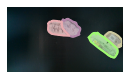

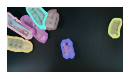

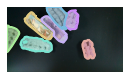

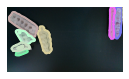

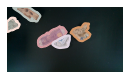

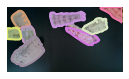

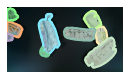

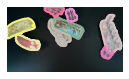

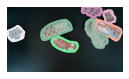

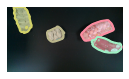

In [ ]:
# CHECK
ANNOTATION_FILE = "/content/manually_labelled/annotations/new_annotations_2.json"
coco = COCO(ANNOTATION_FILE)
cats = coco.loadCats(coco.getCatIds())
imgIds = coco.getImgIds(catIds=coco.getCatIds(cats))
for num, Id in enumerate(imgIds[:10]):
    curImg = coco.imgs[Id]
    image = skimage.io.imread("/content/manually_labelled/train2019/" + curImg['file_name'])
    plt.figure(figsize=(100,200))
    plt.subplot(len(imgIds),1,num+1)
    plt.imshow(image); plt.axis('off')
    annotation_ids = coco.getAnnIds(imgIds=curImg['id'], catIds=[1], iscrowd=None)
    annotations = coco.loadAnns(annotation_ids)
    coco.showAnns(annotations)